In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import random
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Concatenate, GlobalAveragePooling1D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder


In [2]:
%pip install yfinance pandas
%pip install fredapi
%pip install xlrd
%pip install pandas_ta
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow
%pip install scikeras
%pip install arch
%pip install shap
%pip install neuralforecast
%pip install neuralforecast pytorch-lightning torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import seaborn as sns
import shap
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.ensemble import AdaBoostRegressor

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import (Input, LSTM, Bidirectional, Dense, Dropout, LayerNormalization,MultiHeadAttention, Concatenate)
import random
import pandas as pd
from neuralforecast.models import Autoformer
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MSE
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.auto import Autoformer
from neuralforecast.losses.pytorch import MSE
from ray import tune
from neuralforecast.auto import Informer





# PREP

In [5]:
df = pd.read_csv("/content/gold_fixed_auto.csv", parse_dates=["ds"],thousands =',')
df.set_index("ds",inplace= True)
df.dropna(inplace=True)

price_features = [
    'Open', 'High','Close', 'Low', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14', 'MACD',
    'BB_Width', 'Volume_Zscore',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'rolling_vol_5', 'rolling_vol_20',
    'abs_return', 'intraday_range', 'ATR_14',
    'trend_up', 'strong_momentum',
    'pos_in_range'
]

macro_features = [
    'Fed_Funds_Rate', 'CPI', 'Unemployment_Rate', 'M2', 'M1', 'IPI',
    'Consumer_Sentiment', '1Y_Treasury_Rate', 'GDP_Quarterly', 'Balance_Trade','SP500_Close',
       'SP500_log_return', 'SP500_SMA_30', 'SP500_RSI_14', 'DXY_Close',
       'DXY_Log_Return', 'VIX_Close', 'GPRD', 'GPRD_ACT',
       'GPRD_THREAT', 'GPRD_MA7', 'GPRD_MA30'
]


# --- 2. Extract raw feature matrices ---
X_price_raw = df[price_features].values
X_macro_raw = df[macro_features].values
#y = silver['Close'].values  # next-day price difference
# Instead of predicting Price_t+2

y = df['y']
df = df.iloc[:-1]  # Drop last row to align with y

# --- 3. Scale features and target separately ---
scaler_price = StandardScaler()
scaler_macro = StandardScaler()
scaler_target = StandardScaler()

X_price_scaled = scaler_price.fit_transform(X_price_raw)
X_macro_scaled = scaler_macro.fit_transform(X_macro_raw)
y_scaled = scaler_target.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()
X_price_scaled = X_price_scaled[:-1]
X_macro_scaled = X_macro_scaled[:-1]

def create_dual_sequences(X_price, X_macro, y, lookback, horizon=1):
    Xp, Xm, yt = [], [], []
    for i in range(lookback, len(X_price) - horizon + 1):
        Xp.append(X_price[i - lookback:i])
        Xm.append(X_macro[i - lookback:i])
        yt.append(y[i:i + horizon])  # Now yt is a 2-element array
    return np.array(Xp), np.array(Xm), np.array(yt)

lookback = 30
horizon = 1
Xp_seq, Xm_seq, y_seq = create_dual_sequences(X_price_scaled, X_macro_scaled, y_scaled, lookback, horizon)
dates_seq = df.index[lookback:lookback + len(y_seq)]


years = range(2020, 2025)
results = []

for year in years:
    # Define masks
    train_mask = dates_seq < np.datetime64(f'{year}-01-01')
    test_mask = (dates_seq >= np.datetime64(f'{year}-01-01')) & (dates_seq < np.datetime64(f'{year+1}-01-01'))

    # Extract sets
    Xp_train, Xm_train, y_train = Xp_seq[train_mask], Xm_seq[train_mask], y_seq[train_mask]
    Xp_test, Xm_test, y_test = Xp_seq[test_mask], Xm_seq[test_mask], y_seq[test_mask]

    if len(y_test) == 0 or len(y_train) == 0:
        print(f"⚠ Skipping year {year} — insufficient data.")
        continue

    print(f"\n Training until {year}, testing on {year} ({len(y_test)} samples)")



 Training until 2020, testing on 2020 (253 samples)

 Training until 2021, testing on 2021 (252 samples)

 Training until 2022, testing on 2022 (251 samples)

 Training until 2023, testing on 2023 (250 samples)

 Training until 2024, testing on 2024 (229 samples)


# STACKED LSTM PRICE

# MERGED AFTER FEED FORWARD LAYERING


 Walk-forward for year 2020
 Year 2020 — MSE: 700.803696, RMSE: 26.472697, MAE: 19.391295, R²: -0.2567, DA: 42.69%

 Walk-forward for year 2021
 Year 2021 — MSE: 284.758405, RMSE: 16.874786, MAE: 12.040895, R²: -0.0134, DA: 47.62%

 Walk-forward for year 2022
 Year 2022 — MSE: 399.279073, RMSE: 19.981969, MAE: 15.413467, R²: -0.2843, DA: 49.40%

 Walk-forward for year 2023
 Year 2023 — MSE: 264.001280, RMSE: 16.248116, MAE: 12.024426, R²: -0.0131, DA: 52.80%

 Walk-forward for year 2024
 Year 2024 — MSE: 577.833628, RMSE: 24.038170, MAE: 18.321160, R²: -0.1008, DA: 47.83%


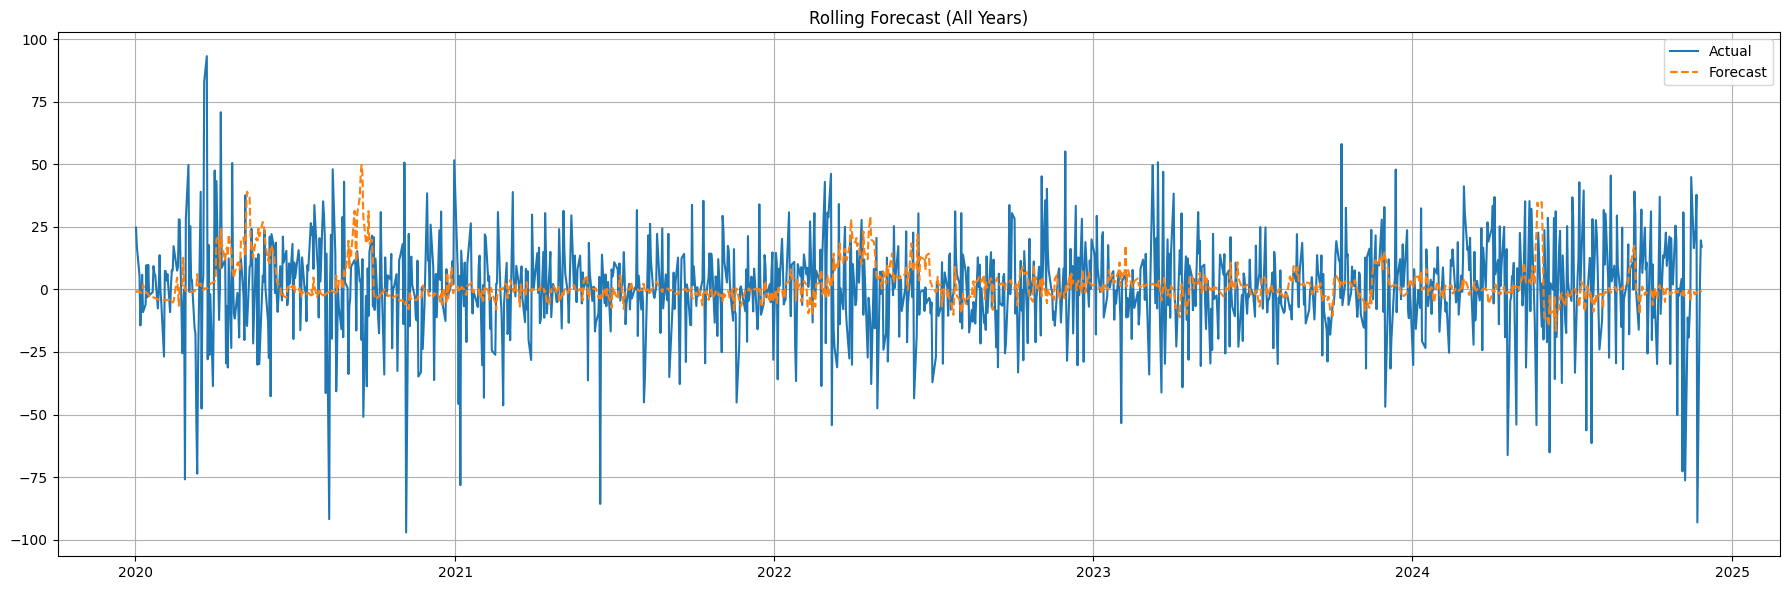

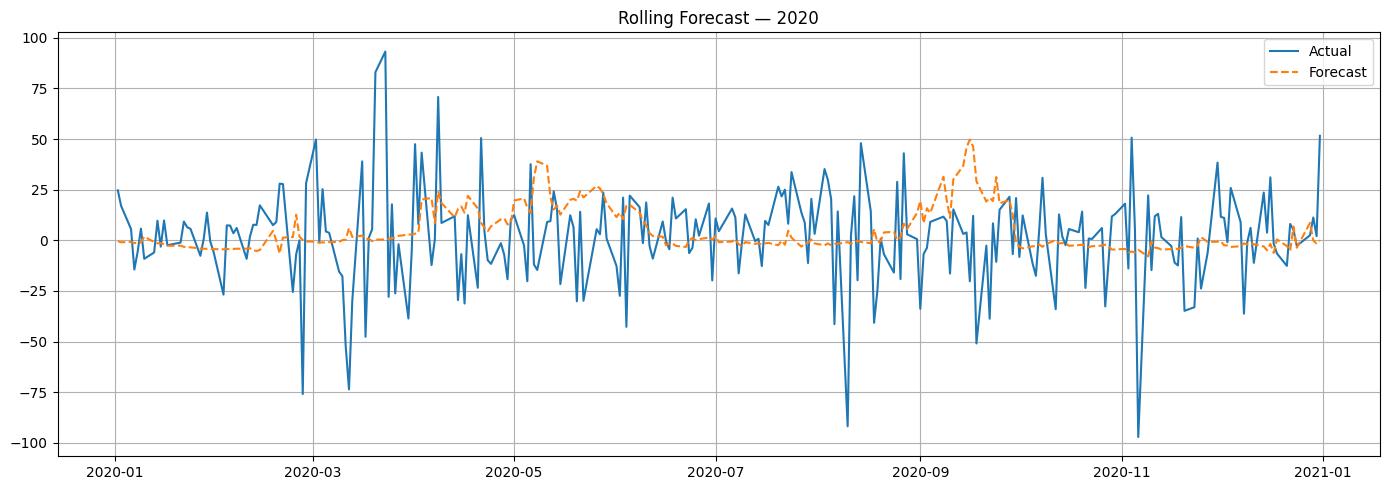

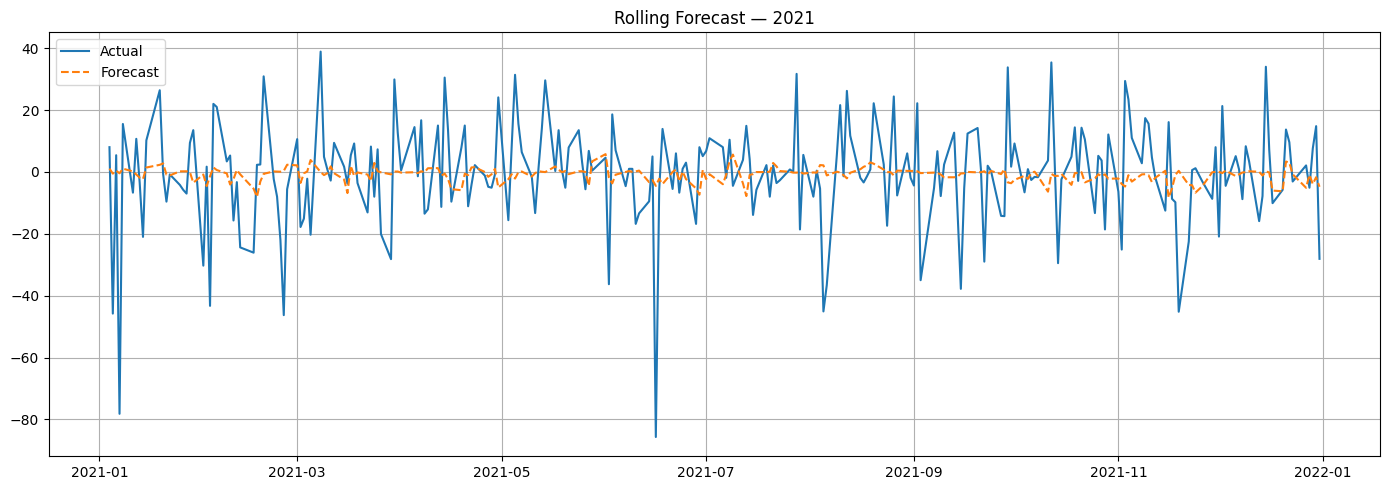

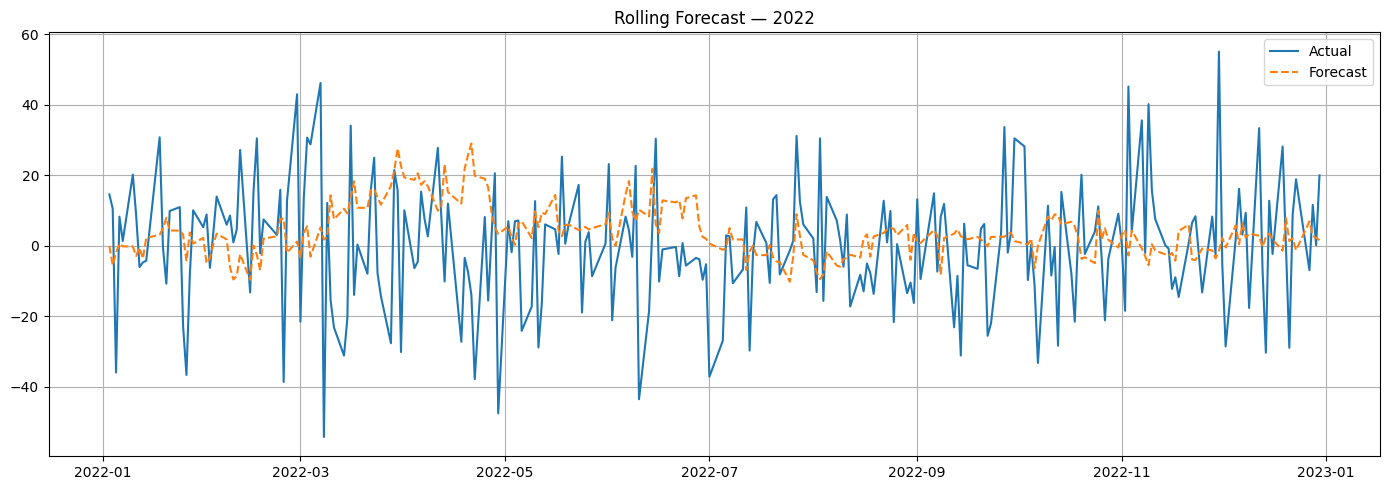

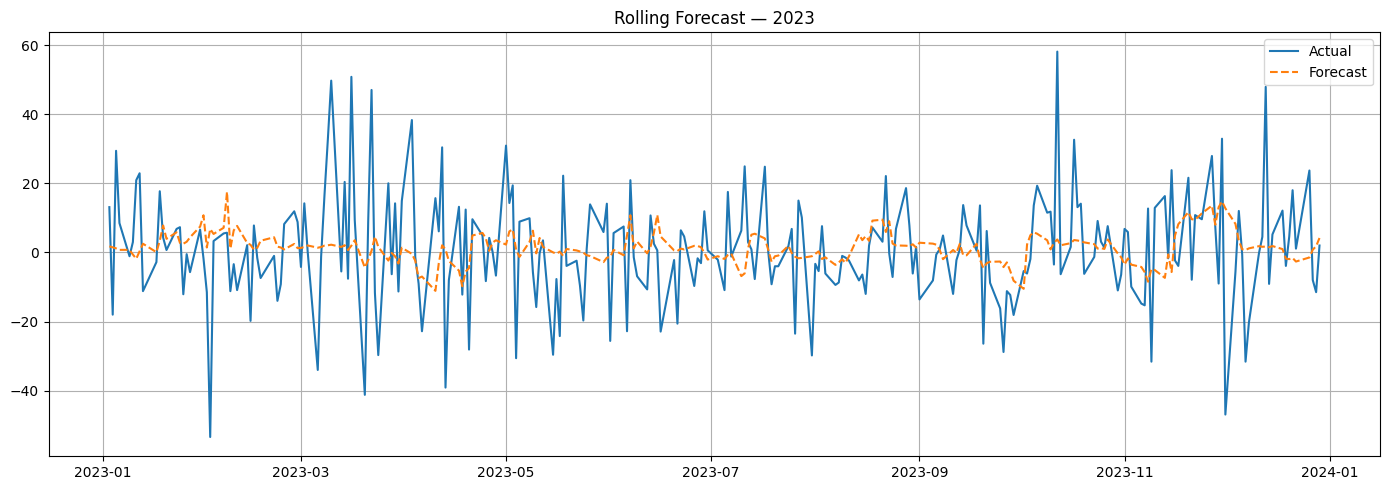

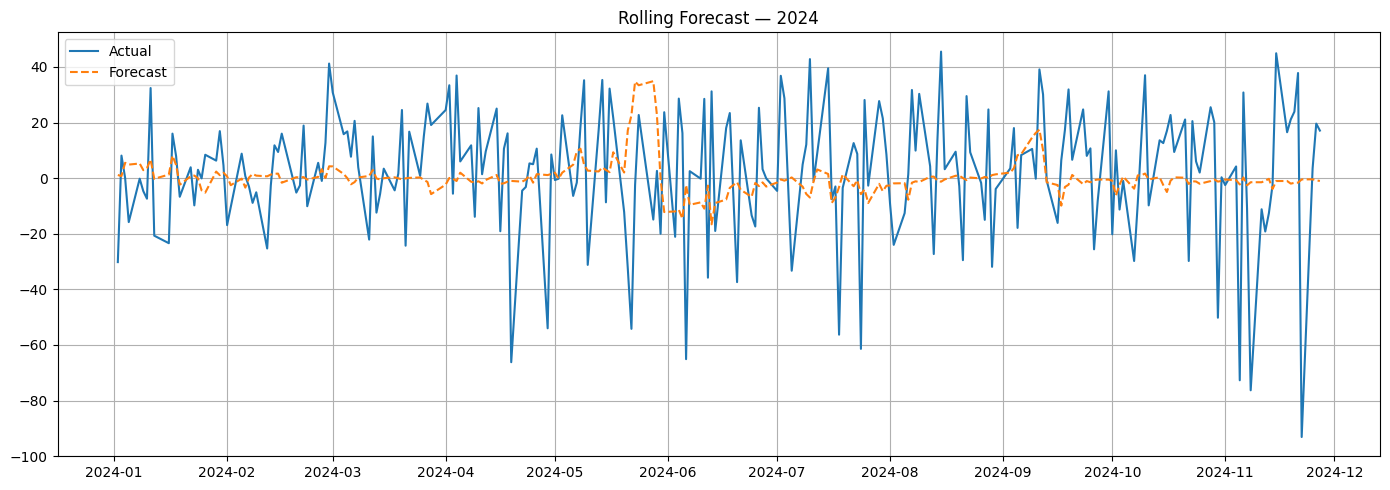


--- Average Metrics Across All Years ---
MSE                     445.3352
RMSE                     20.7231
MAE                      15.4382
R2                       -0.1337
Directional Accuracy      0.4807
dtype: float64


In [7]:
# --- Set seed ---
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# --- Parameters ---
lookback = 30
H = 1 # Horizon for prediction
years = range(2020, 2025)



# --- Load and prepare data ---
df = pd.read_csv("/content/gold_fixed_auto.csv", parse_dates=["ds"], thousands=',')
df.set_index("ds", inplace=True)
df.dropna(inplace=True)

price_features = [
    'Open', 'High','Close', 'Low', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14', 'MACD',
    'BB_Width', 'Volume_Zscore',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'rolling_vol_5', 'rolling_vol_20',
    'abs_return', 'intraday_range', 'ATR_14',
    'trend_up', 'strong_momentum',
    'pos_in_range'
]

macro_features = [
    'Fed_Funds_Rate', 'CPI', 'Unemployment_Rate', 'M2', 'M1', 'IPI',
    'Consumer_Sentiment', '1Y_Treasury_Rate', 'GDP_Quarterly', 'Balance_Trade','SP500_Close',
    'SP500_log_return', 'SP500_SMA_30', 'SP500_RSI_14', 'DXY_Close',
    'DXY_Log_Return', 'VIX_Close', 'GPRD', 'GPRD_ACT',
    'GPRD_THREAT', 'GPRD_MA7', 'GPRD_MA30'
]

X_price_raw = df[price_features].values
X_macro_raw = df[macro_features].values
y = df['y']

scaler_price = StandardScaler()
scaler_macro = StandardScaler()
scaler_target = StandardScaler()

X_price_scaled = scaler_price.fit_transform(X_price_raw)
X_macro_scaled = scaler_macro.fit_transform(X_macro_raw)
y_scaled = scaler_target.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()

def create_dual_sequences(X_price, X_macro, y, lookback, horizon=1):
    Xp, Xm, yt = [], [], []
    for i in range(lookback, len(X_price) - horizon + 1):
        Xp.append(X_price[i - lookback:i])
        Xm.append(X_macro[i - lookback:i])
        yt.append(y[i + horizon - 1])
    return np.array(Xp), np.array(Xm), np.array(yt)

Xp_seq, Xm_seq, y_seq = create_dual_sequences(X_price_scaled, X_macro_scaled, y_scaled, lookback, H)
dates_seq = df.index[lookback + H - 1 : lookback + H - 1 + len(y_seq)]

def build_model_stacked_lstm(n_price_features, n_macro_features):
    price_input = Input(shape=(lookback, n_price_features), name='price_input')
    macro_input = Input(shape=(lookback, n_macro_features), name='macro_input')

    x_price = GRU(64, return_sequences=True)(price_input)
    x_price = Dropout(0.001)(x_price)
    x_price = GRU(64, return_sequences=True)(x_price)
    x_price = Dropout(0)(x_price)
    x_price = GRU(64, return_sequences=True)(x_price)
    x_price = LayerNormalization()(x_price)

    x_macro = GRU(128, return_sequences=True)(macro_input)
    x_macro = Dropout(0.001)(x_macro)
    x_macro = GRU(64, return_sequences=True)(x_macro)
    x_macro = LayerNormalization()(x_macro)

    fused = Concatenate()([x_price, x_macro])
    fused = Dense(128, activation='gelu')(fused)
    fused = Dropout(0.001)(fused)
    fused = Dense(64, activation='gelu')(fused)

    pooled = GlobalAveragePooling1D()(fused)
    output = Dense(H, activation='linear', name='price_prediction')(pooled)

    model = Model(inputs=[price_input, macro_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

    return model

results = []
all_preds = []

n_price_features = Xp_seq.shape[2]
n_macro_features = Xm_seq.shape[2]

for year in years:
    print(f"\n Walk-forward for year {year}")
    train_mask = dates_seq < np.datetime64(f'{year}-01-01')
    test_mask = (dates_seq >= np.datetime64(f'{year}-01-01')) & (dates_seq < np.datetime64(f'{year + 1}-01-01'))

    Xp_train, Xm_train, y_train = Xp_seq[train_mask], Xm_seq[train_mask], y_seq[train_mask]
    Xp_test, Xm_test, y_test = Xp_seq[test_mask], Xm_seq[test_mask], y_seq[test_mask]

    if len(y_train) == 0 or len(y_test) == 0:
        print(f" Skipping {year} due to insufficient data for training or testing.")
        continue

    model = build_model_stacked_lstm(n_price_features, n_macro_features)

    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)
    ]

    model.fit([
        Xp_train, Xm_train
    ], y_train, epochs=25, batch_size=32, verbose=0, callbacks=callbacks)

    y_pred_scaled = model.predict([Xp_test, Xm_test], verbose=0)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1,1))
    y_true = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    dir_acc = (np.sign(y_true.flatten()) == np.sign(y_pred.flatten())).mean()

    print(f" Year {year} — MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}, DA: {dir_acc:.2%}")
    results.append((year, mse, rmse, mae, r2, dir_acc))

    df_preds = pd.DataFrame({
        'ds': dates_seq[test_mask],
        'y_true': y_true.flatten(),
        'y_pred': y_pred.flatten(),
        'year': year
    })
    all_preds.append(df_preds)

# --- Evaluation Summary ---
if all_preds:
    all_preds_df = pd.concat(all_preds, ignore_index=True)

    y_true = all_preds_df['y_true']
    y_pred = all_preds_df['y_pred']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    da = (np.sign(y_true) == np.sign(y_pred)).mean()

    # Combined plot
    plt.figure(figsize=(18, 6))
    plt.plot(all_preds_df['ds'], all_preds_df['y_true'], label='Actual')
    plt.plot(all_preds_df['ds'], all_preds_df['y_pred'], label='Forecast', linestyle='--')
    plt.title('Rolling Forecast (All Years)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Per-year plots
    for year in years:
        df_year = all_preds_df[all_preds_df['year'] == year]
        if not df_year.empty:
            plt.figure(figsize=(14, 5))
            plt.plot(df_year['ds'], df_year['y_true'], label='Actual')
            plt.plot(df_year['ds'], df_year['y_pred'], label='Forecast', linestyle='--')
            plt.title(f'Rolling Forecast — {year}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Average metrics
    results_df = pd.DataFrame(results, columns=['Year', 'MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy'])
    avg_metrics = results_df[['MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy']].mean()

    print("\n--- Average Metrics Across All Years ---")
    print(avg_metrics.round(4))
else:
    print("\n No predictions were generated. Check your training/test splits and data continuity.")

# TFT + LSTM


 Walk-forward for year 2020


 Year 2020 — MSE: 579.356835, RMSE: 24.069832, MAE: 16.774626, R²: -0.0389, DA: 57.31%

 Walk-forward for year 2021
 Year 2021 — MSE: 305.804151, RMSE: 17.487257, MAE: 12.433669, R²: -0.0883, DA: 47.62%

 Walk-forward for year 2022
 Year 2022 — MSE: 316.578676, RMSE: 17.792658, MAE: 13.434707, R²: -0.0183, DA: 54.58%

 Walk-forward for year 2023
 Year 2023 — MSE: 272.838647, RMSE: 16.517828, MAE: 12.365574, R²: -0.0471, DA: 50.80%

 Walk-forward for year 2024
 Year 2024 — MSE: 538.683721, RMSE: 23.209561, MAE: 17.516230, R²: -0.0262, DA: 42.61%

--- Evaluation Metrics (All Years) ---
RMSE: 20.0163
MSE : 400.653795
MAE : 14.4575
R²  : -0.0376
Directional Accuracy: 50.73%


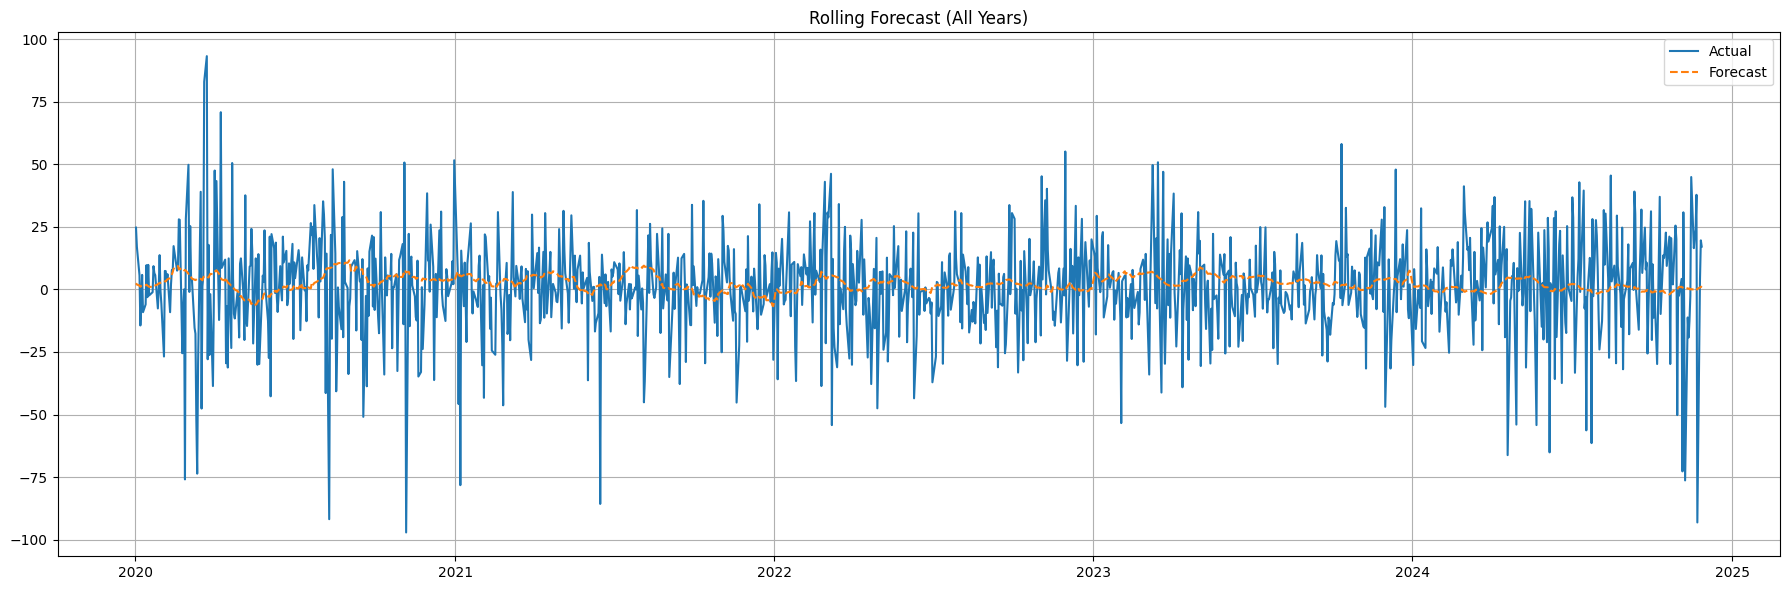

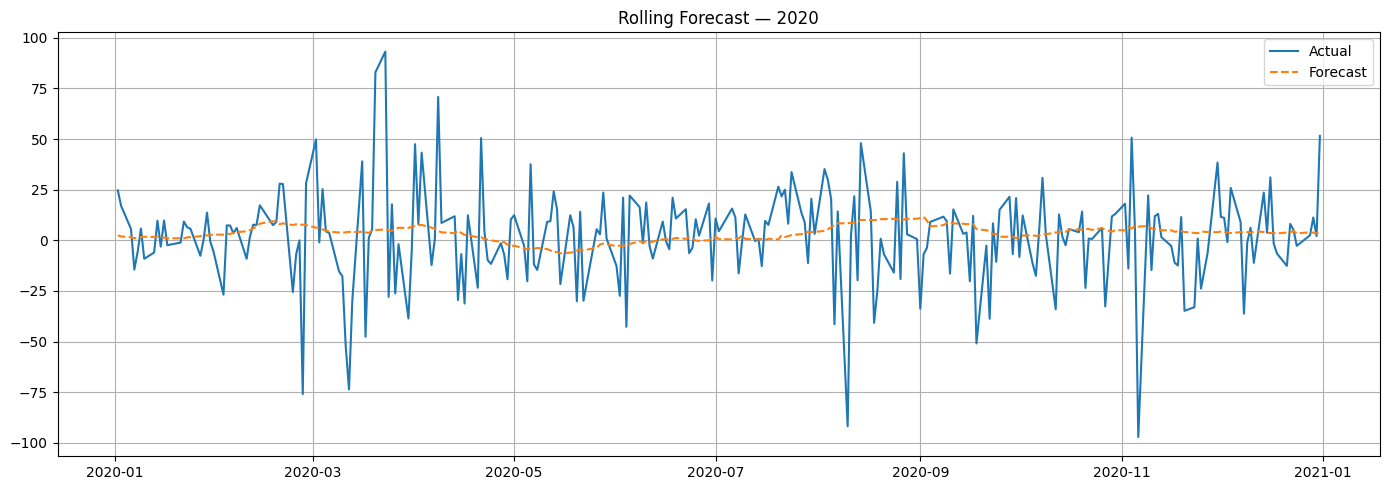

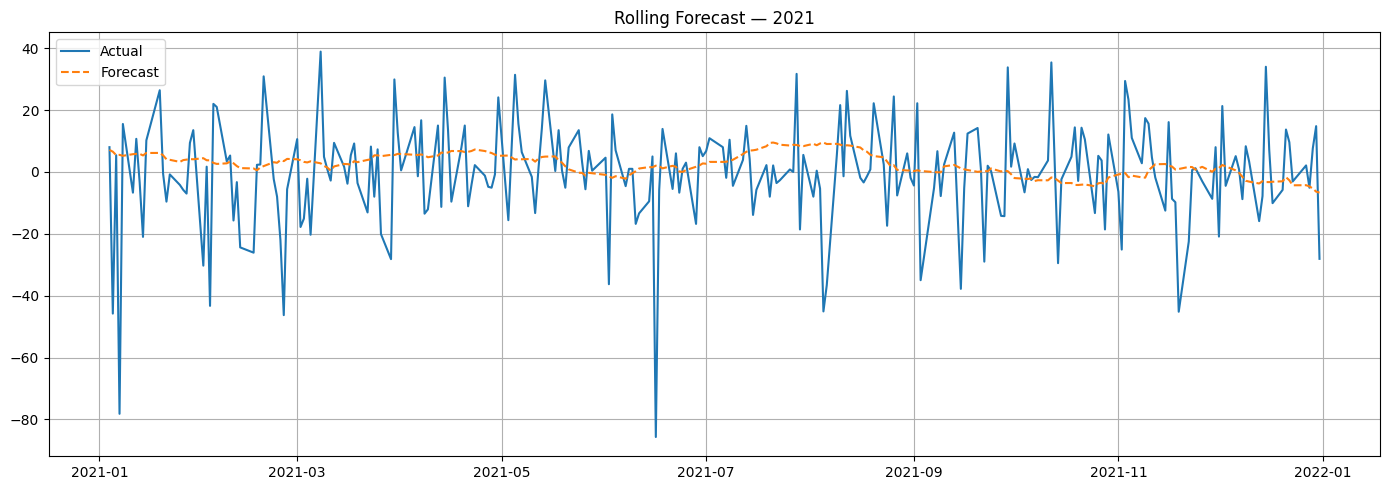

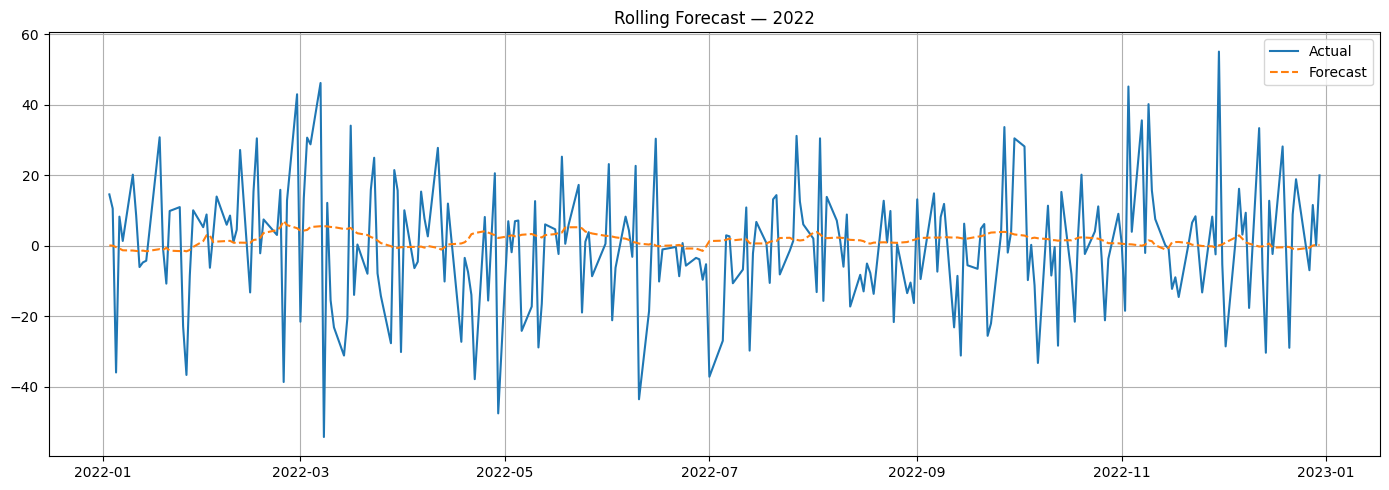

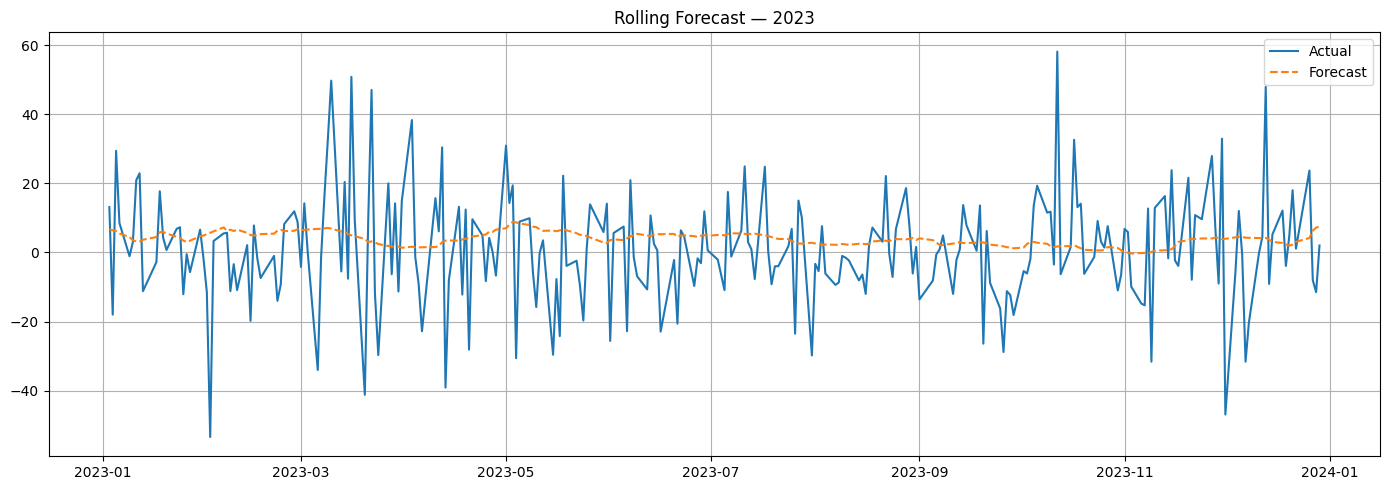

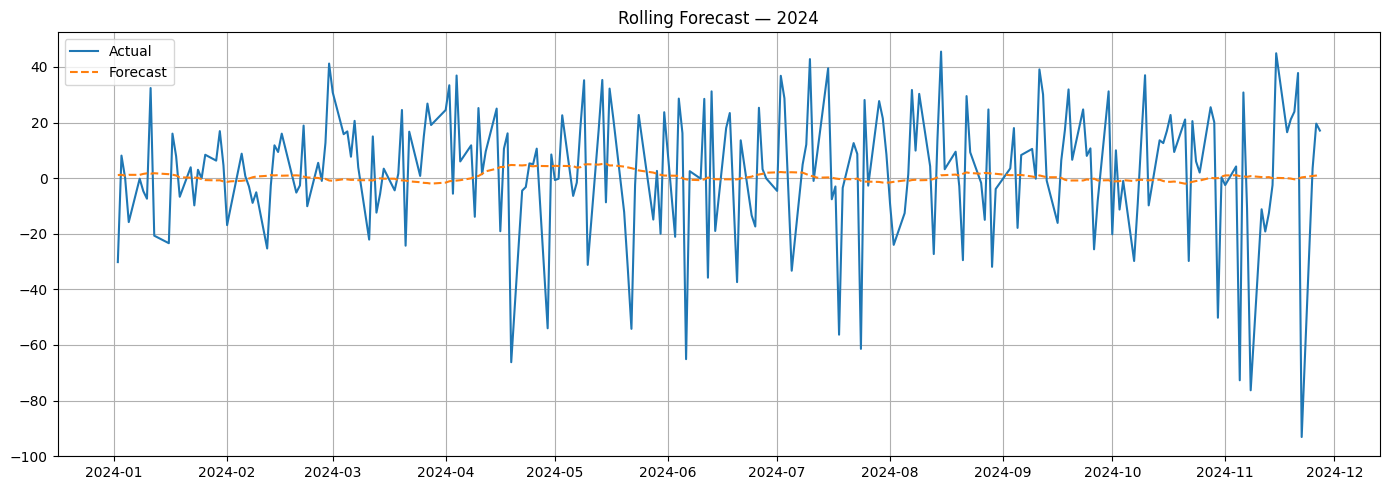


--- Average Metrics Across All Years ---
MSE                     402.6524
RMSE                     19.8154
MAE                      14.5050
R2                       -0.0438
Directional Accuracy      0.5058
dtype: float64


In [4]:
# --- Set seed ---
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# --- Parameters ---
lookback = 30
H = 1 # Horizon for prediction
years = range(2020, 2025)



# --- Load and prepare data ---
df = pd.read_csv("/content/gold_fixed_auto.csv", parse_dates=["ds"], thousands=',')
df.set_index("ds", inplace=True)
df.dropna(inplace=True)

price_features = [
    'Open', 'High','Close', 'Low', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14', 'MACD',
    'BB_Width', 'Volume_Zscore',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'rolling_vol_5', 'rolling_vol_20',
    'abs_return', 'intraday_range', 'ATR_14',
    'trend_up', 'strong_momentum',
    'pos_in_range'
]

macro_features = [
    'Fed_Funds_Rate', 'CPI', 'Unemployment_Rate', 'M2', 'M1', 'IPI',
    'Consumer_Sentiment', '1Y_Treasury_Rate', 'GDP_Quarterly', 'Balance_Trade','SP500_Close',
    'SP500_log_return', 'SP500_SMA_30', 'SP500_RSI_14', 'DXY_Close',
    'DXY_Log_Return', 'VIX_Close', 'GPRD', 'GPRD_ACT',
    'GPRD_THREAT', 'GPRD_MA7', 'GPRD_MA30'
]

X_price_raw = df[price_features].values
X_macro_raw = df[macro_features].values
y = df['y']

scaler_price = StandardScaler()
scaler_macro = StandardScaler()
scaler_target = StandardScaler()

X_price_scaled = scaler_price.fit_transform(X_price_raw)
X_macro_scaled = scaler_macro.fit_transform(X_macro_raw)
y_scaled = scaler_target.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()

def create_dual_sequences(X_price, X_macro, y, lookback, horizon=1):
    Xp, Xm, yt = [], [], []
    for i in range(lookback, len(X_price) - horizon + 1):
        Xp.append(X_price[i - lookback:i])
        Xm.append(X_macro[i - lookback:i])
        yt.append(y[i + horizon - 1])
    return np.array(Xp), np.array(Xm), np.array(yt)

Xp_seq, Xm_seq, y_seq = create_dual_sequences(X_price_scaled, X_macro_scaled, y_scaled, lookback, H)
dates_seq = df.index[lookback + H - 1 : lookback + H - 1 + len(y_seq)]

def build_model(n_price_features, n_macro_features):
    price_input = Input(shape=(lookback, n_price_features), name='price_input')
    macro_input = Input(shape=(lookback, n_macro_features), name='macro_input')

    # Add Conv1D before LSTM to capture local patterns

    # LSTM for price data after convolution
    lstm_out = LSTM(128, return_sequences=True)(price_input)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = LayerNormalization()(lstm_out)

    # Transformer-style encoder for macro data
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(macro_input, macro_input)
    attn_out = Dropout(0.0)(attn_out)
    attn_out = LayerNormalization()(attn_out)
    dense_macro = Dense(64, activation='gelu')(attn_out)

    # Cross Attention: price attends to macro
    cross_attn = MultiHeadAttention(num_heads=4, key_dim=16)(lstm_out, dense_macro)
    cross_attn = Dropout(0.0)(cross_attn)
    cross_attn = LayerNormalization()(cross_attn)

    # Fusion
    fused = Concatenate()([lstm_out, cross_attn])
    fused = Dense(64, activation='gelu')(fused)
    fused = Dropout(0.00)(fused)
    fused = Dense(32, activation='gelu')(fused)

    # Output
    res_out = GlobalAveragePooling1D()(fused)
    output = Dense(H, activation='linear', name='price_prediction')(res_out)

    model = Model(inputs=[price_input, macro_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'mse'])

    return model


results = []
all_preds = []

n_price_features = Xp_seq.shape[2]
n_macro_features = Xm_seq.shape[2]

for year in years:
    print(f"\n Walk-forward for year {year}")
    train_mask = dates_seq < np.datetime64(f'{year}-01-01')
    test_mask = (dates_seq >= np.datetime64(f'{year}-01-01')) & (dates_seq < np.datetime64(f'{year + 1}-01-01'))

    Xp_train, Xm_train, y_train = Xp_seq[train_mask], Xm_seq[train_mask], y_seq[train_mask]
    Xp_test, Xm_test, y_test = Xp_seq[test_mask], Xm_seq[test_mask], y_seq[test_mask]

    if len(y_train) == 0 or len(y_test) == 0:
        print(f" Skipping {year} due to insufficient data for training or testing.")
        continue

    model = build_model(n_price_features, n_macro_features)

    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)
    ]

    model.fit([
        Xp_train, Xm_train
    ], y_train, epochs=25, batch_size=32, verbose=0, callbacks=callbacks)

    y_pred_scaled = model.predict([Xp_test, Xm_test], verbose=0)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1,1))
    y_true = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    dir_acc = (np.sign(y_true.flatten()) == np.sign(y_pred.flatten())).mean()

    print(f" Year {year} — MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}, DA: {dir_acc:.2%}")
    results.append((year, mse, rmse, mae, r2, dir_acc))

    df_preds = pd.DataFrame({
        'ds': dates_seq[test_mask],
        'y_true': y_true.flatten(),
        'y_pred': y_pred.flatten(),
        'year': year
    })
    all_preds.append(df_preds)

# --- Evaluation Summary ---
if all_preds:
    all_preds_df = pd.concat(all_preds, ignore_index=True)

    y_true = all_preds_df['y_true']
    y_pred = all_preds_df['y_pred']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    da = (np.sign(y_true) == np.sign(y_pred)).mean()

    print("\n--- Evaluation Metrics (All Years) ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE : {mse:.6f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print(f"Directional Accuracy: {da:.2%}")

    # Combined plot
    plt.figure(figsize=(18, 6))
    plt.plot(all_preds_df['ds'], all_preds_df['y_true'], label='Actual')
    plt.plot(all_preds_df['ds'], all_preds_df['y_pred'], label='Forecast', linestyle='--')
    plt.title('Rolling Forecast (All Years)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Per-year plots
    for year in years:
        df_year = all_preds_df[all_preds_df['year'] == year]
        if not df_year.empty:
            plt.figure(figsize=(14, 5))
            plt.plot(df_year['ds'], df_year['y_true'], label='Actual')
            plt.plot(df_year['ds'], df_year['y_pred'], label='Forecast', linestyle='--')
            plt.title(f'Rolling Forecast — {year}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Average metrics
    results_df = pd.DataFrame(results, columns=['Year', 'MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy'])
    avg_metrics = results_df[['MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy']].mean()

    print("\n--- Average Metrics Across All Years ---")
    print(avg_metrics.round(4))
else:
    print("\n No predictions were generated. Check your training/test splits and data continuity.")

# TRANSFORMER VANILLA


🚀 Walk-forward for year 2020
📊 Year 2020 — MSE: 0.001529, RMSE: 0.039098, MAE: 0.029133, R²: -0.0341, DA: 57.31%

🚀 Walk-forward for year 2021
📊 Year 2021 — MSE: 0.005094, RMSE: 0.071373, MAE: 0.054529, R²: -0.0133, DA: 51.59%

🚀 Walk-forward for year 2022


📊 Year 2022 — MSE: 0.004915, RMSE: 0.070109, MAE: 0.054376, R²: 0.0048, DA: 49.40%

🚀 Walk-forward for year 2023


📊 Year 2023 — MSE: 0.002484, RMSE: 0.049837, MAE: 0.038837, R²: -0.0375, DA: 52.00%

🚀 Walk-forward for year 2024
📊 Year 2024 — MSE: 0.004105, RMSE: 0.064068, MAE: 0.047932, R²: 0.0001, DA: 49.57%

--- Evaluation Metrics (All Years) ---
RMSE: 0.0601
MSE : 0.003616
MAE : 0.0449
R²  : -0.0091
Directional Accuracy: 52.02%


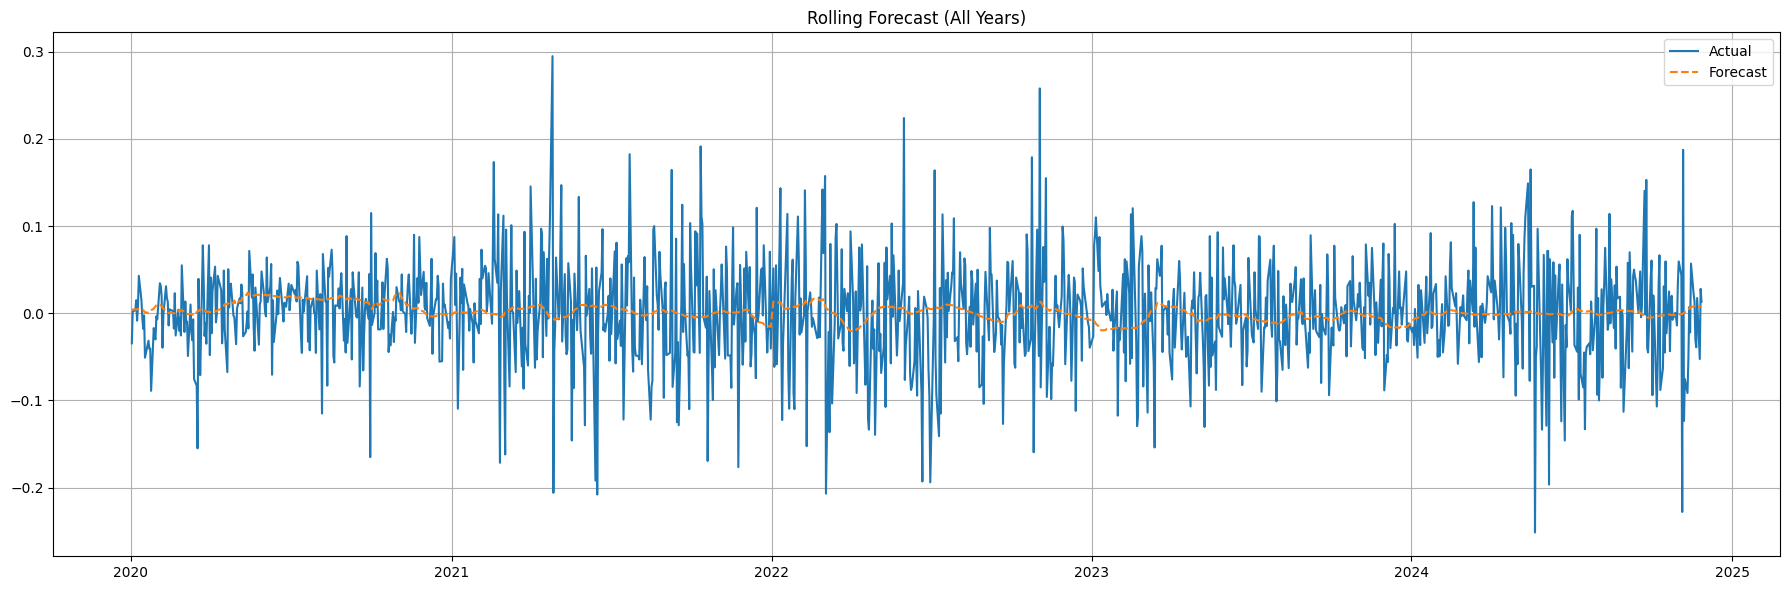

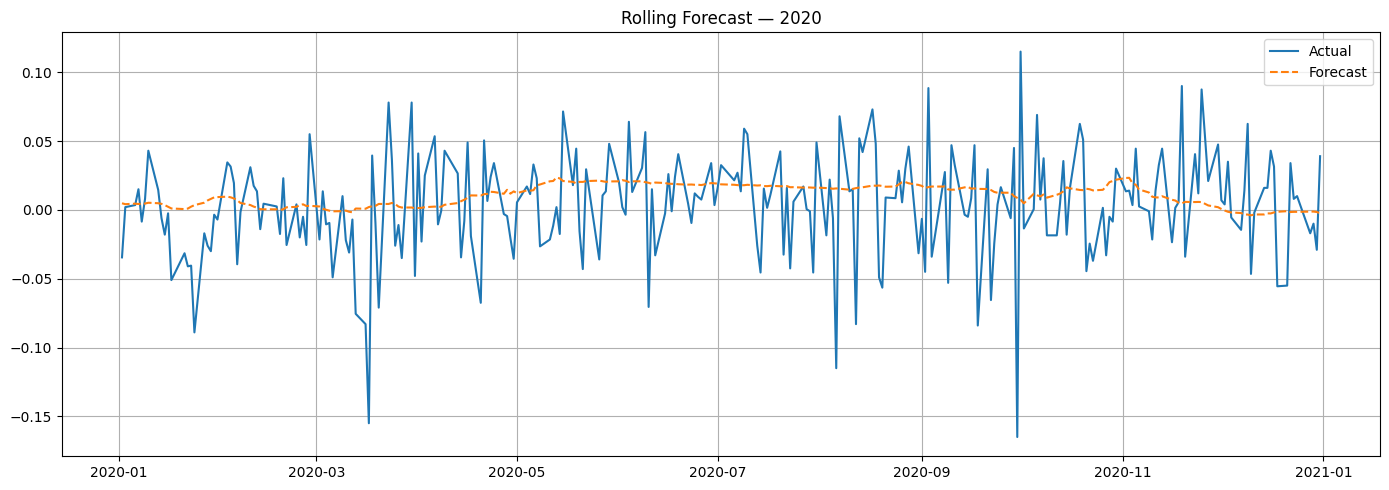

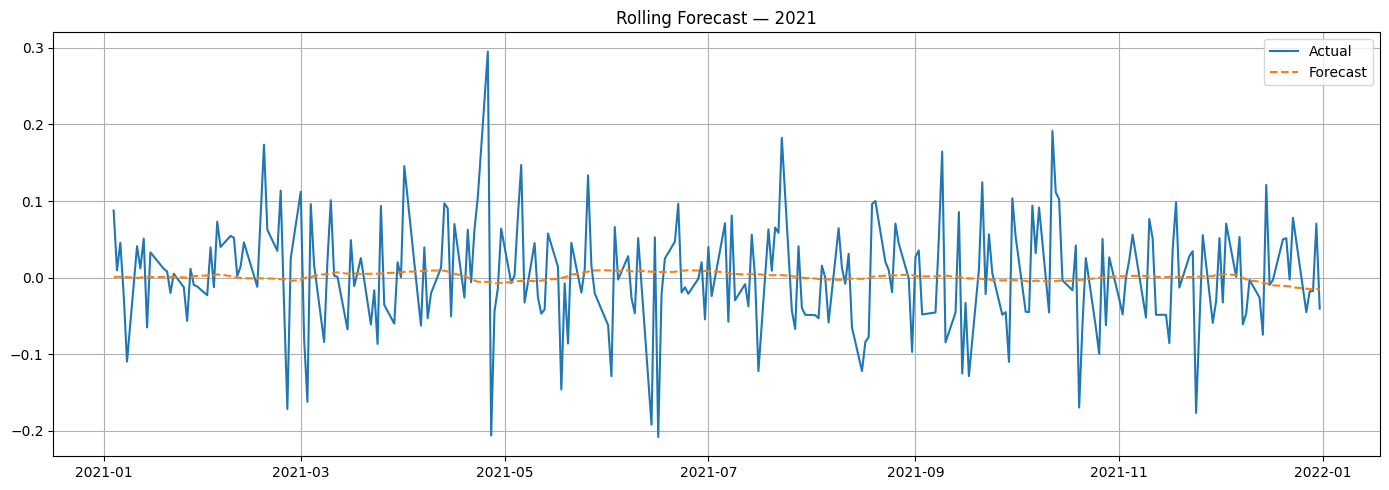

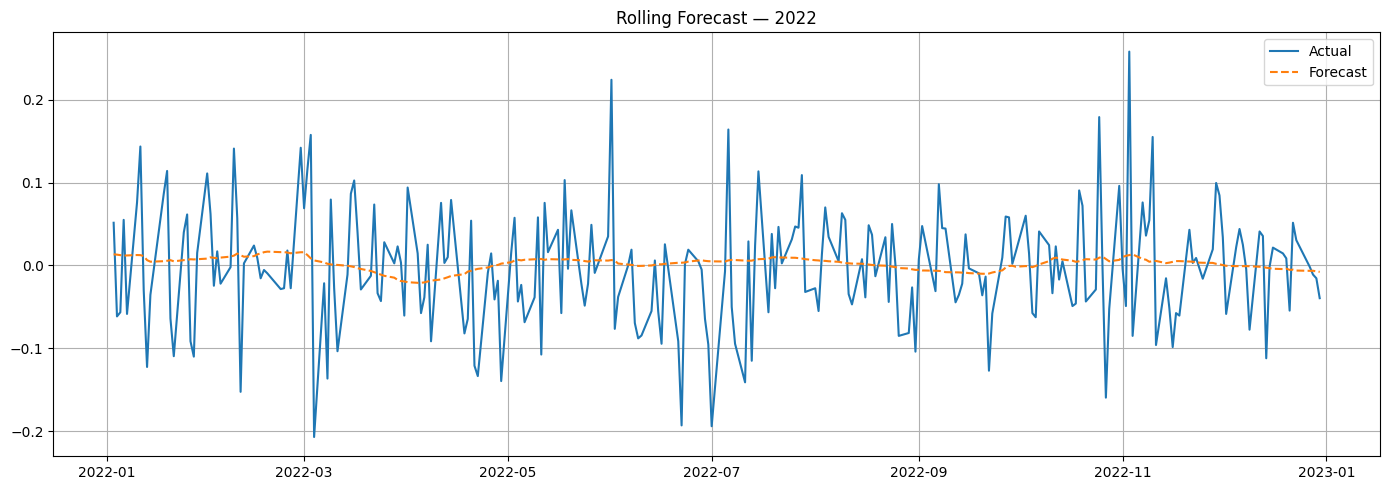

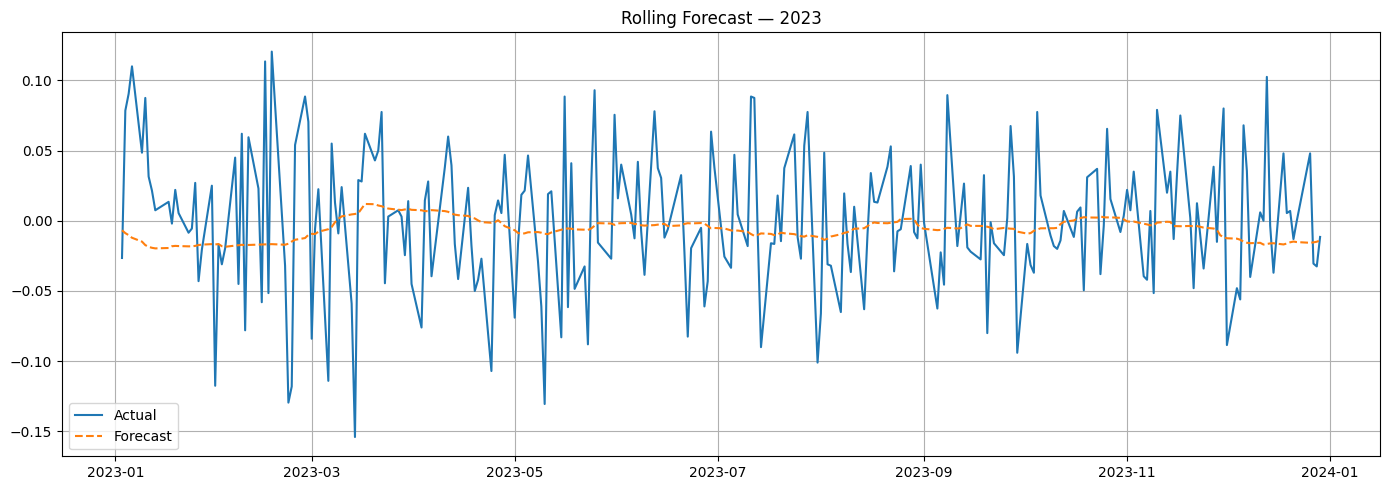

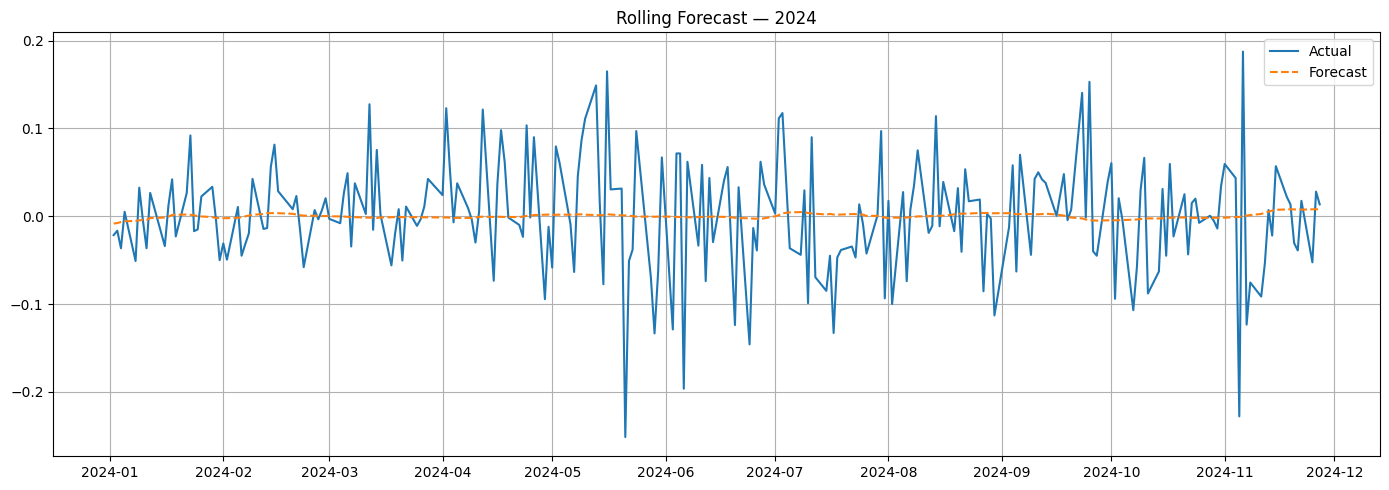


--- Average Metrics Across All Years ---
MSE                     0.0036
RMSE                    0.0589
MAE                     0.0450
R2                     -0.0160
Directional Accuracy    0.5197
dtype: float64


In [3]:
# --- Set seed ---
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


# --- Parameters ---
lookback = 30
H = 1 # Horizon for prediction
years = range(2020, 2025)



# --- Load and prepare data ---
df = pd.read_csv("/content/copper_fixed_auto.csv", parse_dates=["ds"], thousands=',')
df.set_index("ds", inplace=True)
df.dropna(inplace=True)

price_features = [
    'Open', 'High','Close', 'Low', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14', 'MACD',
    'BB_Width', 'Volume_Zscore',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'rolling_vol_5', 'rolling_vol_20',
    'abs_return', 'intraday_range', 'ATR_14',
    'trend_up', 'strong_momentum',
    'pos_in_range'
]

macro_features = [
    'Fed_Funds_Rate', 'CPI', 'Unemployment_Rate', 'M2', 'M1', 'IPI',
    'Consumer_Sentiment', '1Y_Treasury_Rate', 'GDP_Quarterly', 'Balance_Trade','SP500_Close',
    'SP500_log_return', 'SP500_SMA_30', 'SP500_RSI_14', 'DXY_Close',
    'DXY_Log_Return', 'VIX_Close', 'GPRD', 'GPRD_ACT',
    'GPRD_THREAT', 'GPRD_MA7', 'GPRD_MA30'
]

X_price_raw = df[price_features].values
X_macro_raw = df[macro_features].values
y = df['y']

scaler_price = StandardScaler()
scaler_macro = StandardScaler()
scaler_target = StandardScaler()

X_price_scaled = scaler_price.fit_transform(X_price_raw)
X_macro_scaled = scaler_macro.fit_transform(X_macro_raw)
y_scaled = scaler_target.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()

def create_dual_sequences(X_price, X_macro, y, lookback, horizon=1):
    Xp, Xm, yt = [], [], []
    for i in range(lookback, len(X_price) - horizon + 1):
        Xp.append(X_price[i - lookback:i])
        Xm.append(X_macro[i - lookback:i])
        yt.append(y[i + horizon - 1])
    return np.array(Xp), np.array(Xm), np.array(yt)

Xp_seq, Xm_seq, y_seq = create_dual_sequences(X_price_scaled, X_macro_scaled, y_scaled, lookback, H)
dates_seq = df.index[lookback + H - 1 : lookback + H - 1 + len(y_seq)]

def build_model_transformer_only(n_price_features, n_macro_features):
    price_input = Input(shape=(lookback, n_price_features), name='price_input')
    macro_input = Input(shape=(lookback, n_macro_features), name='macro_input')

    # Transformer for price
    price_attn = MultiHeadAttention(num_heads=4, key_dim=16)(price_input, price_input)
    price_attn = Dropout(0)(price_attn)
    price_attn = LayerNormalization()(price_attn)
    price_attn = Dense(64, activation='gelu')(price_attn)

    # Transformer for macro
    macro_attn = MultiHeadAttention(num_heads=4, key_dim=16)(macro_input, macro_input)
    macro_attn = Dropout(0)(macro_attn)
    macro_attn = LayerNormalization()(macro_attn)
    macro_attn = Dense(64, activation='gelu')(macro_attn)

    # Cross Attention: price attends to macro
    cross_attn = MultiHeadAttention(num_heads=4, key_dim=16)(price_attn, macro_attn)
    cross_attn = Dropout(0)(cross_attn)
    cross_attn = LayerNormalization()(cross_attn)

    # Fusion
    fused = Concatenate()([price_attn, cross_attn])
    fused = Dense(64, activation='gelu')(fused)
    fused = Dropout(0.00)(fused)
    fused = Dense(64, activation='gelu')(fused)

    pooled = GlobalAveragePooling1D()(fused)
    output = Dense(H, activation='linear', name='price_prediction')(pooled)

    model = Model(inputs=[price_input, macro_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'mse'])

    return model

results = []
all_preds = []

n_price_features = Xp_seq.shape[2]
n_macro_features = Xm_seq.shape[2]

for year in years:
    print(f"\n Walk-forward for year {year}")
    train_mask = dates_seq < np.datetime64(f'{year}-01-01')
    test_mask = (dates_seq >= np.datetime64(f'{year}-01-01')) & (dates_seq < np.datetime64(f'{year + 1}-01-01'))

    Xp_train, Xm_train, y_train = Xp_seq[train_mask], Xm_seq[train_mask], y_seq[train_mask]
    Xp_test, Xm_test, y_test = Xp_seq[test_mask], Xm_seq[test_mask], y_seq[test_mask]

    if len(y_train) == 0 or len(y_test) == 0:
        print(f" Skipping {year} due to insufficient data for training or testing.")
        continue

    model = build_model_transformer_only(n_price_features, n_macro_features)

    callbacks = [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)
    ]

    model.fit([
        Xp_train, Xm_train
    ], y_train, epochs=25, batch_size=32, verbose=0, callbacks=callbacks)

    y_pred_scaled = model.predict([Xp_test, Xm_test], verbose=0)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1,1))
    y_true = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    dir_acc = (np.sign(y_true.flatten()) == np.sign(y_pred.flatten())).mean()

    print(f" Year {year} — MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}, DA: {dir_acc:.2%}")
    results.append((year, mse, rmse, mae, r2, dir_acc))

    df_preds = pd.DataFrame({
        'ds': dates_seq[test_mask],
        'y_true': y_true.flatten(),
        'y_pred': y_pred.flatten(),
        'year': year
    })
    all_preds.append(df_preds)

# --- Evaluation Summary ---
if all_preds:
    all_preds_df = pd.concat(all_preds, ignore_index=True)

    y_true = all_preds_df['y_true']
    y_pred = all_preds_df['y_pred']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    da = (np.sign(y_true) == np.sign(y_pred)).mean()

    print("\n--- Evaluation Metrics (All Years) ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE : {mse:.6f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print(f"Directional Accuracy: {da:.2%}")

    # Combined plot
    plt.figure(figsize=(18, 6))
    plt.plot(all_preds_df['ds'], all_preds_df['y_true'], label='Actual')
    plt.plot(all_preds_df['ds'], all_preds_df['y_pred'], label='Forecast', linestyle='--')
    plt.title('Rolling Forecast (All Years)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Per-year plots
    for year in years:
        df_year = all_preds_df[all_preds_df['year'] == year]
        if not df_year.empty:
            plt.figure(figsize=(14, 5))
            plt.plot(df_year['ds'], df_year['y_true'], label='Actual')
            plt.plot(df_year['ds'], df_year['y_pred'], label='Forecast', linestyle='--')
            plt.title(f'Rolling Forecast — {year}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Average metrics
    results_df = pd.DataFrame(results, columns=['Year', 'MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy'])
    avg_metrics = results_df[['MSE', 'RMSE', 'MAE', 'R2', 'Directional Accuracy']].mean()

    print("\n--- Average Metrics Across All Years ---")
    print(avg_metrics.round(4))
else:
    print("\n No predictions were generated. Check your training/test splits and data continuity.")